In [1]:
##################################################################################################################################
#                                                                                                                                #
#                             An Explainable AI Framework for Satellite Network Anomaly Detection                                #
#                                                                                                                                #
#                                                                                                                                #
#                     *******   SES Maneuver Risk Prediction with Space-Weather Augmentation   *******                           #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

In [1]:
# ============================================
# 0. Setup and Imports
# ============================================

import os
import requests
import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

!pip install shap -q
import shap


In [2]:

# ============================================
# 1. Mountong the Google Drive and Define Paths
# ============================================

drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
print("DATA_DIR:", DATA_DIR)
!ls "$DATA_DIR"

CIEL2_FILE = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
SES_FEATURES_FILE = os.path.join(DATA_DIR, "ses_maneuver_features.csv")  # will be created
MERGED_FILE = os.path.join(DATA_DIR, "ses_spaceweather_dataset.csv")


Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses
 3_3_SES_Jamming_Interference.ipynb
' 3_3_SES_Prototype_BeamHandover.ipynb'
 3_3_SES_Prototype_SignalLoss.ipynb
 3_3_SES_Prototype_SLA_Proxy.ipynb
 3_3_SES_Space_Weather.ipynb
 Archive
 artifacts_handover
 artifacts_jamming
 artifacts_powerfault
 artifacts_signal_loss
 artifacts_sla
 AttitudePIDs.csv
 CIEL2_ManeuverEvents_R1.csv
 gfz_kp_ap_2012-01-01_2020-02-27.csv
 gfz_kp_ap_2023.csv
 LabelManeuverEvents.m
 phase3_ESA-Mission1
 Remove__3_3_SES_Space_Weather_v2.ipynb
 Removed___3_3_SES_Prototype_PowerLoss.ipynb
 ses_clean_10s.parquet
 ses_comm_anomalies.csv
 ses_comm_features.csv
 SESGroundData_Oct-Nov_AS1.xlsx
 ses_maneuver_features.csv
 ses_spaceweather_dataset.csv
 space_weather_gfz_kp_ap_2023_v1.csv
 ThrusterTemperaturePIDs.csv


In [3]:

# ============================================
# 2. Build SES Maneuver Feature File from CIEL2
# ============================================

# Uses the real maneuver SES catalogue (times + types) from CIEL2 data file,
# and then generate telemetry-like features + a synthetic label.
# "This is a methodological dataset, not a real operational one".

man_raw = pd.read_csv(
    CIEL2_FILE,
    header=None,
    names=["start_str", "end_str", "maneuver_type"]
)

# Parsing datetimes (month/day/year hour:minute)
man_raw["start_time"] = pd.to_datetime(man_raw["start_str"])
man_raw["end_time"] = pd.to_datetime(man_raw["end_str"])
man_raw["duration_sec"] = (man_raw["end_time"] - man_raw["start_time"]).dt.total_seconds()

# Basic maneuver flags
man_raw["is_unload"] = (man_raw["maneuver_type"].str.upper() == "UNLOAD_MAN").astype(int)
man_raw["is_stationkeeping"] = man_raw["maneuver_type"].str.upper().isin(
    ["EAST_MAN", "WEST_MAN", "NORTH_MAN", "SOUTH_MAN"]
).astype(int)

# Using start time as the reference timestamp, localize as UTC-like
man_raw["time"] = man_raw["start_time"].dt.tz_localize("UTC")

# ---- Synthetic telemetry-like features ----
rng = np.random.default_rng(42)
n = len(man_raw)

# Base temperature depends on maneuver type
base_temp = 45 + 3 * man_raw["is_stationkeeping"] + 2 * man_raw["is_unload"]

thr_temp_mean = rng.normal(loc=base_temp, scale=4, size=n)
thr_temp_std = np.clip(rng.normal(loc=2.0, scale=0.5, size=n), 0.1, None)
thr_temp_max = thr_temp_mean + np.abs(rng.normal(loc=8, scale=3, size=n))
thr_temp_min = thr_temp_mean - np.abs(rng.normal(loc=8, scale=3, size=n))
thr_temp_slope = rng.normal(loc=0.1 + 0.05 * man_raw["is_unload"], scale=0.05, size=n)

att_err_mean = np.clip(
    rng.normal(loc=0.1 + 0.02 * man_raw["is_stationkeeping"], scale=0.05, size=n),
    0,
    None
)
att_err_max = att_err_mean + np.abs(rng.normal(loc=0.2, scale=0.1, size=n))
att_err_std = np.clip(rng.normal(loc=0.05, scale=0.02, size=n), 0.01, None)

# Synthetic risk score for label generation
risk_score = (
    0.03 * np.clip(thr_temp_max - 55, 0, None) +
    2.0  * np.clip(att_err_max - 0.35, 0, None) +
    0.0001 * np.clip(man_raw["duration_sec"] - 1800, 0, None)
)
prob = 1 / (1 + np.exp(-risk_score))
maneuver_risky = (rng.random(n) < prob).astype(int)

ses_feats = pd.DataFrame({
    "time": man_raw["time"],
    "maneuver_type": man_raw["maneuver_type"],
    "duration_sec": man_raw["duration_sec"],
    "is_unload": man_raw["is_unload"],
    "is_stationkeeping": man_raw["is_stationkeeping"],
    "thr_temp_mean": thr_temp_mean,
    "thr_temp_max": thr_temp_max,
    "thr_temp_min": thr_temp_min,
    "thr_temp_std": thr_temp_std,
    "thr_temp_slope": thr_temp_slope,
    "att_err_mean": att_err_mean,
    "att_err_max": att_err_max,
    "att_err_std": att_err_std,
    "maneuver_risky": maneuver_risky,
})

ses_feats.to_csv(SES_FEATURES_FILE, index=False)
print("SES maneuver features saved to:", SES_FEATURES_FILE)
print(ses_feats.head())


SES maneuver features saved to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/ses_maneuver_features.csv
                       time maneuver_type  duration_sec  is_unload  \
0 2012-01-01 07:34:00+00:00    UNLOAD_MAN         360.0          1   
1 2012-01-04 07:22:00+00:00    UNLOAD_MAN         420.0          1   
2 2012-01-05 14:37:00+00:00    UNLOAD_MAN         300.0          1   
3 2012-01-05 14:47:00+00:00      EAST_MAN         900.0          0   
4 2012-01-08 07:07:00+00:00    UNLOAD_MAN         300.0          1   

   is_stationkeeping  thr_temp_mean  thr_temp_max  thr_temp_min  thr_temp_std  \
0                  0      48.218868     55.231707     38.862106      2.275929   
1                  0      42.840064     50.072594     32.856238      0.541420   
2                  0      50.001805     60.564524     47.347002      2.595153   
3                  1      51.762259     60.455289     40.358662      0.476184   
4                  0      39.195859     47.901728     28

In [4]:

# ============================================
# 3. Downloading GFZ Kp/ap i.e. "space weather" for the Maneuver Time Range
# ============================================

def get_gfz_index(start, end, index_name="Kp", status="def"):
    """
    Download GFZ geomagnetic indices (Kp, ap, etc.) between start and end dates.
    Returns a DataFrame indexed by time with a single column named index_name.
    """
    base_url = "https://kp.gfz.de/app/json/"
    params = {
        "start": f"{start}T00:00:00Z",
        "end": f"{end}T23:59:59Z",
        "index": index_name,
        "status": status
    }

    r = requests.get(base_url, params=params)
    r.raise_for_status()

    data_json = r.json()

    if (
        not isinstance(data_json, dict)
        or "datetime" not in data_json
        or index_name not in data_json
    ):
        print(f"Warning: Unexpected data format for {index_name}. Raw data: {data_json}")
        return pd.DataFrame(columns=["time", index_name]).set_index("time")

    df = pd.DataFrame({
        "time": data_json["datetime"],
        index_name: data_json[index_name]
    })

    if df.empty:
        print(f"Warning: No data received for {index_name} between {start} and {end}.")
        return pd.DataFrame(columns=["time", index_name]).set_index("time")

    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time").sort_index()
    return df[[index_name]]

# Computing maneuver time window and adding a small margin
ses_feats = pd.read_csv(SES_FEATURES_FILE, parse_dates=["time"])
ses_feats = ses_feats.sort_values("time")

ses_start = ses_feats["time"].min().normalize()
ses_end = ses_feats["time"].max().normalize()

start_str = ses_start.strftime("%Y-%m-%d")
end_str = ses_end.strftime("%Y-%m-%d")
print("Maneuver time window:", start_str, "to", end_str)

kp_df = get_gfz_index(start_str, end_str, "Kp")
ap_df = get_gfz_index(start_str, end_str, "ap")

kp_ap_df = kp_df.join(ap_df, how="outer")
kp_ap_df_reset = kp_ap_df.reset_index()  # 'time' as column

gfz_file = os.path.join(DATA_DIR, f"gfz_kp_ap_{start_str}_{end_str}.csv")
kp_ap_df_reset.to_csv(gfz_file, index=False)

print("GFZ data saved to:", gfz_file)
print(kp_ap_df_reset.head())


Maneuver time window: 2012-01-01 to 2020-02-27
GFZ data saved to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/gfz_kp_ap_2012-01-01_2020-02-27.csv
                       time     Kp   ap
0 2012-01-01 00:00:00+00:00  1.667  6.0
1 2012-01-01 03:00:00+00:00  1.000  4.0
2 2012-01-01 06:00:00+00:00  0.667  3.0
3 2012-01-01 09:00:00+00:00  0.333  2.0
4 2012-01-01 12:00:00+00:00  1.667  6.0


In [5]:

# ============================================
# 4. Engineering Space-Weather Features and Merging the files
# ============================================

# Reloading cleanly
df_ses = pd.read_csv(SES_FEATURES_FILE, parse_dates=["time"]).sort_values("time")
df_ses = df_ses.set_index("time")

df_kp_ap = pd.read_csv(gfz_file, parse_dates=["time"]).sort_values("time")
df_kp_ap = df_kp_ap.set_index("time")

# Ensuring 3-hour frequency for Kp/ap and engineer rolling features
df_kp_ap = df_kp_ap.asfreq("3H")

df_kp_ap["Kp_prev12h_max"] = df_kp_ap["Kp"].rolling(window=4, min_periods=1).max()
df_kp_ap["Kp_prev24h_max"] = df_kp_ap["Kp"].rolling(window=8, min_periods=1).max()
df_kp_ap["is_storm"] = (df_kp_ap["Kp"] >= 5).astype(int)
df_kp_ap["storm_intensity"] = np.clip(df_kp_ap["Kp"] - 5, 0, None)

print("GFZ with engineered features:")
print(df_kp_ap.head())

# Merge via asof: each SES maneuver gets nearest-past Kp/ap info
df_merged = pd.merge_asof(
    df_ses.reset_index().sort_values("time"),
    df_kp_ap.reset_index().sort_values("time"),
    on="time",
    direction="backward"
)

df_merged.to_csv(MERGED_FILE, index=False)
print("Merged SES + space-weather dataset saved to:", MERGED_FILE)
print(df_merged.head())


/tmp/ipython-input-1396856006.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_kp_ap = df_kp_ap.asfreq("3H")


GFZ with engineered features:
                              Kp   ap  Kp_prev12h_max  Kp_prev24h_max  \
time                                                                    
2012-01-01 00:00:00+00:00  1.667  6.0           1.667           1.667   
2012-01-01 03:00:00+00:00  1.000  4.0           1.667           1.667   
2012-01-01 06:00:00+00:00  0.667  3.0           1.667           1.667   
2012-01-01 09:00:00+00:00  0.333  2.0           1.667           1.667   
2012-01-01 12:00:00+00:00  1.667  6.0           1.667           1.667   

                           is_storm  storm_intensity  
time                                                  
2012-01-01 00:00:00+00:00         0              0.0  
2012-01-01 03:00:00+00:00         0              0.0  
2012-01-01 06:00:00+00:00         0              0.0  
2012-01-01 09:00:00+00:00         0              0.0  
2012-01-01 12:00:00+00:00         0              0.0  
Merged SES + space-weather dataset saved to: /content/drive/MyDrive/Colab

In [6]:

# ============================================
# 5. Training the Model on the Merged Dataset
# ============================================

df_model = pd.read_csv(MERGED_FILE, parse_dates=["time"])

LABEL_COL = "maneuver_risky"
df_model = df_model.dropna(subset=[LABEL_COL])

non_feature_cols = ["time", "maneuver_type", LABEL_COL]
feature_cols = [c for c in df_model.columns if c not in non_feature_cols]

X = df_model[feature_cols]
y = df_model[LABEL_COL].astype(int)

X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)

print("Feature columns:", feature_cols)
print("X shape:", X.shape, "y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


/tmp/ipython-input-2475002196.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)


Feature columns: ['duration_sec', 'is_unload', 'is_stationkeeping', 'thr_temp_mean', 'thr_temp_max', 'thr_temp_min', 'thr_temp_std', 'thr_temp_slope', 'att_err_mean', 'att_err_max', 'att_err_std', 'Kp', 'ap', 'Kp_prev12h_max', 'Kp_prev24h_max', 'is_storm', 'storm_intensity']
X shape: (1912, 17) y shape: (1912,)
Classification report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.44       270
           1       0.52      0.57      0.55       304

    accuracy                           0.50       574
   macro avg       0.49      0.49      0.49       574
weighted avg       0.50      0.50      0.50       574

Confusion matrix:
[[112 158]
 [130 174]]


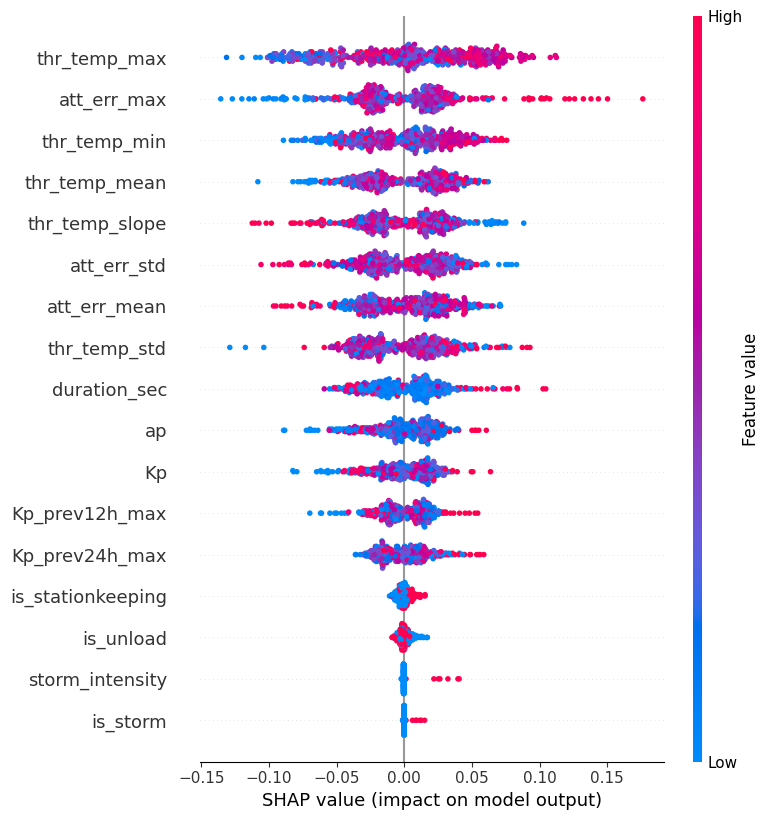

In [7]:
# ============================================
# 6. SHAP Explainability
# ============================================

explainer_sample = X_train.sample(min(500, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(explainer_sample)

# For binary classification: shap_values[:, :, 1] corresponds to the positive class
# The shap_values is a 3D array of shape (n_samples, n_features, n_classes)
shap.summary_plot(shap_values[:, :, 1], explainer_sample, show=False)

In [10]:
# ============================================
# 7. SHAP HEATMAPS
# ============================================

# === Step X: SHAP heatmaps for Space Weather / Maneuver Risk ===
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

plt.close('all')

# ---- 1. Assumptions about variables from previous steps ----
# - df_model: merged SES + space-weather dataframe with a 'time' column
# - feature_cols: list of feature column names (same used for training)
# - clf: trained tree-based classifier for maneuver_risky
# - X_train, X_val, X_test, y_train, y_val, y_test: from your time-based split

# Make sure X_test has a datetime index for nice plotting
# X_test was created from df_model[feature_cols] and has the original integer index.
# We need to map these integer indices back to their original 'time' values from df_model.
if not isinstance(X_test.index, pd.DatetimeIndex):
    # Ensure df_model's 'time' column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_model['time']):
        df_model['time'] = pd.to_datetime(df_model['time'])

    # Get the 'time' column values from the original df_model for the corresponding indices in X_test
    X_test_times = df_model.loc[X_test.index, 'time']
    # Create a new X_test with datetime index
    X_test_with_time_index = X_test.copy()
    X_test_with_time_index.index = X_test_times
    X_test = X_test_with_time_index.sort_index()

# ---- 2. Compute SHAP values on TEST set ----
print("Computing SHAP values for Space Weather model...")
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# For binary classifier, shap_values is a list of two arrays (for class 0 and class 1)
# or a 3D array (n_samples, n_features, n_classes). We want the SHAP values
# for the positive class (class 1).
if isinstance(shap_values, (list, tuple)):
    shap_values = shap_values[1]
else: # assume it's a 3D numpy array
    shap_values = shap_values[:, :, 1]

shap_values = np.array(shap_values)  # (n_samples, n_features)
assert shap_values.shape[0] == X_test.shape[0], f"SHAP values shape {shap_values.shape} does not match X_test shape {X_test.shape}"

# ---- 3. Select top features by mean |SHAP| ----
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:15]   # top 15 features
top_features = [feature_cols[i] for i in top_idx]

shap_top = shap_values[:, top_idx]     # (n_samples, 15)

# Reorder samples by time for a "continuous" view
times_test = pd.to_datetime(X_test.index)
order = np.argsort(times_test.values)
times_sorted = times_test.values[order]
shap_top_sorted = shap_top[order, :]

# ---- 4A. Continuous heatmap over ALL test maneuvers ----
art_dir = os.path.join(DATA_DIR, "artifacts_space_weather")
os.makedirs(art_dir, exist_ok=True)
cont_path = os.path.join(art_dir, "spaceweather_continuous_heatmap.png")

fig, ax = plt.subplots(figsize=(16, 3))
im = ax.imshow(
    shap_top_sorted.T,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-np.max(np.abs(shap_top_sorted)),
    vmax=np.max(np.abs(shap_top_sorted))
)

ax.set_yticks(np.arange(len(top_features)))
ax.set_yticklabels(top_features)
# Sparse x ticks for readability
n_ticks = 10
if len(times_sorted) < n_ticks:
    xticks = np.arange(len(times_sorted))
else:
    xticks = np.linspace(0, len(times_sorted) - 1, n_ticks, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels(pd.to_datetime(times_sorted[xticks]).strftime("%Y-%m-%d"), rotation=45, ha="right")

ax.set_xlabel("Maneuvers over time")
ax.set_title("Space Weather — Continuous SHAP heatmap (test set)")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("SHAP value (impact on log-odds of 'risky')")

plt.tight_layout()
plt.savefig(cont_path, dpi=200)
plt.close(fig)
print(f"Saved continuous heatmap to: {cont_path}")

# ---- 4B. Heatmap for TOP-N highest-risk maneuvers ----
top_n = 40  # you can change this to 20 / 50 etc.
proba_test = clf.predict_proba(X_test)[:, 1]
idx_sorted_risk = np.argsort(-proba_test)[:top_n]

shap_top_risk = shap_top[idx_sorted_risk, :]
times_risk = pd.to_datetime(X_test.index[idx_sorted_risk])

# Order those risky maneuvers by time
order_risk = np.argsort(times_risk.values)
times_risk_sorted = times_risk.values[order_risk]
shap_top_risk_sorted = shap_top_risk[order_risk, :]

event_path = os.path.join(DATA_DIR, "artifacts_space_weather", "spaceweather_risky_heatmap.png") # Add filename to event_path

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    shap_top_risk_sorted.T,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-np.max(np.abs(shap_top_risk_sorted)),
vmax=np.max(np.abs(shap_top_risk_sorted))
)

ax.set_yticks(np.arange(len(top_features)))
ax.set_yticklabels(top_features)
xticks = np.arange(len(times_risk_sorted))
# Show fewer labels for readability
step = max(1, len(xticks) // 8)
ax.set_xticks(xticks[::step])
ax.set_xticklabels(
    pd.to_datetime(times_risk_sorted[::step]).strftime("%Y-%m-%d"),
    rotation=45,
    ha="right"
)

ax.set_xlabel("Top-N highest predicted risk maneuvers (time-ordered)")
ax.set_title(
    f"Space Weather — SHAP heatmap for top {top_n} risky maneuvers"
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("SHAP value (impact on 'risky' prediction)")

plt.tight_layout()
plt.savefig(event_path, dpi=200)
plt.close(fig)
print(f"Saved risky-maneuver heatmap to: {event_path}")

print("=== SHAP heatmaps for Space Weather done. ===")

Computing SHAP values for Space Weather model...
Saved continuous heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_space_weather/spaceweather_continuous_heatmap.png
Saved risky-maneuver heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_space_weather/spaceweather_risky_heatmap.png
=== SHAP heatmaps for Space Weather done. ===


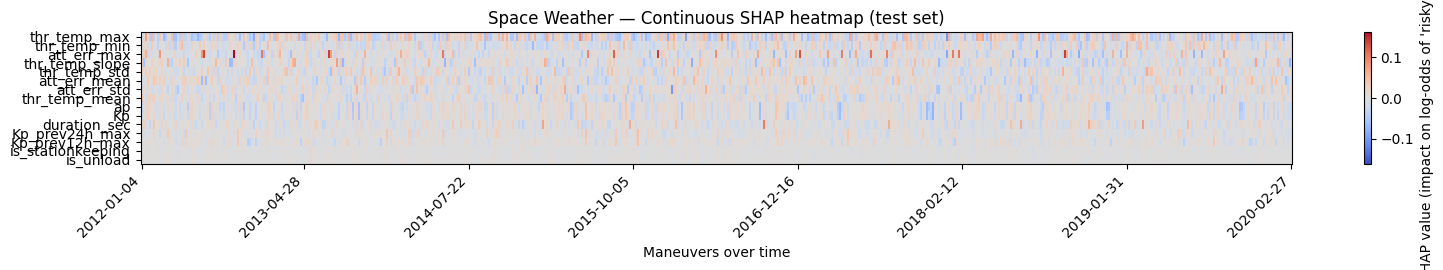

Saved continuous heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_spaceweather/spaceweather_continuous_heatmap.png


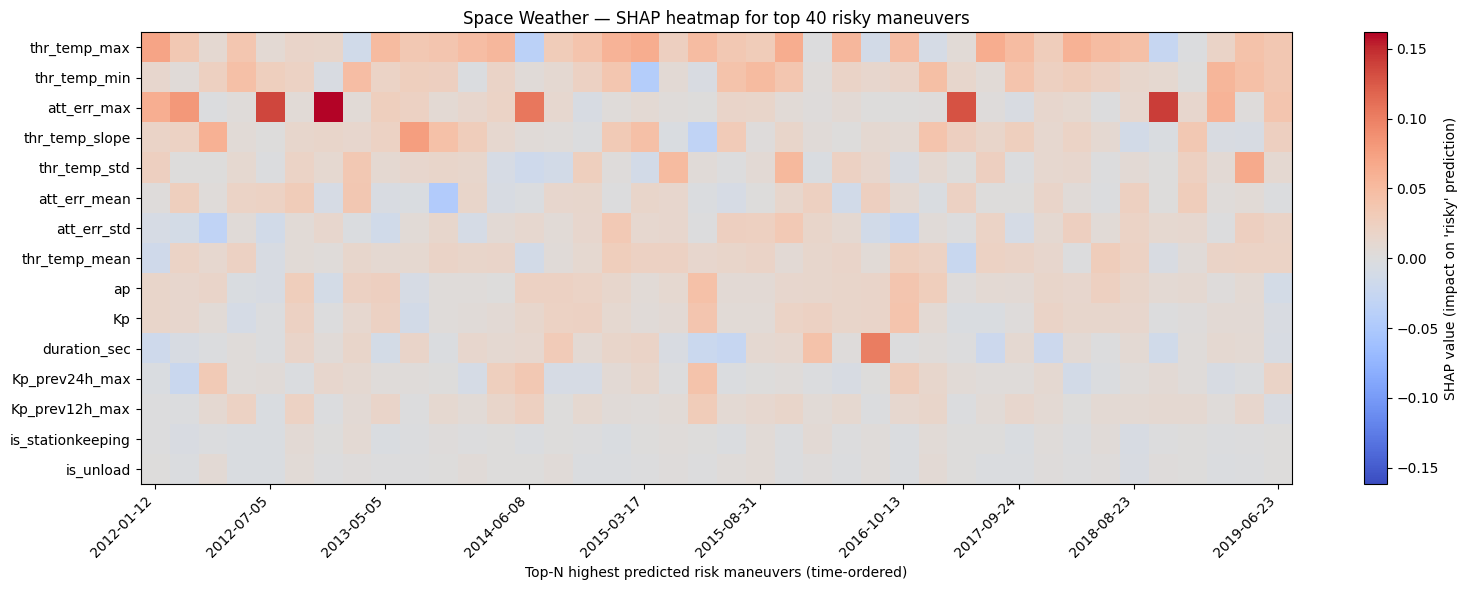

Saved risky-maneuver heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_spaceweather/spaceweather_risky_heatmap.png
=== SHAP heatmaps for Space Weather done. ===


In [12]:
# === Step: SHAP heatmaps for Space Weather (continuous + top-N risky) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 1) Prepare output directory
spaceweather_dir = os.path.join(DATA_DIR, "artifacts_spaceweather")
os.makedirs(spaceweather_dir, exist_ok=True)

# 2) Build / reuse SHAP explainer and compute SHAP values on test set
explainer = shap.TreeExplainer(clf)
shap_raw = explainer.shap_values(X_test)

# Handle binary vs multiclass API
if isinstance(shap_raw, list):
    # assume class 1 ("risky") is index 1
    shap_values = shap_raw[1]
else:
    # If shap_raw is already a 3D array (n_samples, n_features, n_classes),
    # select the SHAP values for the positive class (index 1)
    shap_values = shap_raw[:, :, 1]

feature_names = np.array(X_test.columns)

# 3) Order features by global importance (mean |SHAP|)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_order = np.argsort(mean_abs_shap)[::-1]

# keep top K features for readability (adjust if you like)
K_TOP = min(15, len(feature_names))
feat_order = feat_order[:K_TOP]
top_features = feature_names[feat_order]

# SHAP as DataFrame for convenient indexing
shap_df = pd.DataFrame(shap_values, index=X_test.index, columns=feature_names)
shap_top_df = shap_df[top_features]

# ---------------------------------------------------------------------
# 4) Continuous SHAP heatmap over entire test set (time on x-axis)
# ---------------------------------------------------------------------
# sort by time
shap_cont = shap_top_df.sort_index()
times_cont = shap_cont.index

plt.figure(figsize=(16, 2.8))
im = plt.imshow(
    shap_cont.T,
    aspect="auto",
    cmap="coolwarm",
    vmin=-np.max(np.abs(shap_cont.values)),
    vmax= np.max(np.abs(shap_cont.values)),
    interpolation="nearest",
)

plt.yticks(np.arange(len(top_features)), top_features)
plt.xticks(
    np.linspace(0, len(times_cont) - 1, 8, dtype=int),
    [pd.to_datetime(t).strftime("%Y-%m-%d") for t in
     times_cont[np.linspace(0, len(times_cont) - 1, 8, dtype=int)]],
    rotation=45,
    ha="right"
)
plt.xlabel("Maneuvers over time")
plt.title("Space Weather — Continuous SHAP heatmap (test set)")

cbar = plt.colorbar(im)
cbar.set_label("SHAP value (impact on log-odds of 'risky' maneuver)")

plt.tight_layout()
cont_path = os.path.join(spaceweather_dir, "spaceweather_continuous_heatmap.png")
plt.savefig(cont_path, dpi=200)
plt.show()
print(f"Saved continuous heatmap to: {cont_path}")

# ---------------------------------------------------------------------
# 5) SHAP heatmap for top-N highest-risk maneuvers
# ---------------------------------------------------------------------
# predicted risk scores
proba_test = clf.predict_proba(X_test)[:, 1]
scores = pd.Series(proba_test, index=X_test.index, name="p_risky")

N_TOP = 40  # you can tune this
top_risky = scores.nlargest(N_TOP).sort_index()  # then order by time

shap_risky = shap_top_df.loc[top_risky.index]

plt.figure(figsize=(16, 6))
im2 = plt.imshow(
    shap_risky.T,
    aspect="auto",
    cmap="coolwarm",
    vmin=-np.max(np.abs(shap_risky.values)),
    vmax= np.max(np.abs(shap_risky.values)),
    interpolation="nearest",
)

plt.yticks(np.arange(len(top_features)), top_features)

# show a subset of time labels along x-axis
xticks_idx = np.linspace(0, len(top_risky) - 1, min(10, len(top_risky)), dtype=int)
plt.xticks(
    xticks_idx,
    [pd.to_datetime(t).strftime("%Y-%m-%d") for t in top_risky.index[xticks_idx]],
    rotation=45,
    ha="right"
)

plt.xlabel("Top-N highest predicted risk maneuvers (time-ordered)")
plt.title("Space Weather — SHAP heatmap for top 40 risky maneuvers")

cbar2 = plt.colorbar(im2)
cbar2.set_label("SHAP value (impact on 'risky' prediction)")

plt.tight_layout()
risky_path = os.path.join(spaceweather_dir, "spaceweather_risky_heatmap.png")
plt.savefig(risky_path, dpi=200)
plt.show()
print(f"Saved risky-maneuver heatmap to: {risky_path}")

print("=== SHAP heatmaps for Space Weather done. ===")